In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from fbprophet import Prophet

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

Importing plotly failed. Interactive plots will not work.


[컬럼 설명]

sample_id : 개별 샘플의 인덱스

time : x_df는 0분 ~ 1379분, y_df는 0분 ~ 119분의 값을 갖습니다. 동일한 샘플 내 시간 정보

coin_index : 10가지 종류의 코인에 대한 비식별화 인덱스 (0 ~9)

open : open price, 시가

high : high price, 고가

low : low price, 저가

close : close price, 종가

volume : 거래량

quote_av : quote asset volume

trades : 거래 건 수

tb_base_av : taker buy base asset volume

tb_quote_av : taker buy quote asset volume

# 데이터 불러오기 

In [7]:
train_x = pd.read_csv('./data/train_x_df.csv')
test_x = pd.read_csv('./data/test_x_df.csv')
train_y = pd.read_csv('./data/train_y_df.csv')

In [8]:
train_x.shape, train_y.shape, test_x.shape

((10572180, 12), (919320, 12), (738300, 12))

# 데이터 전처리

In [11]:
# 2차원 데이터를 3차원(sample_id, time, open)데이터로 변환
train_x_open = pd.crosstab(index=train_x['sample_id'], columns=train_x['time'], values=train_x['open'], aggfunc='sum')
train_y_open = pd.crosstab(index=train_y['sample_id'], columns=train_y['time'], values=train_y['open'], aggfunc='sum')
test_x_open = pd.crosstab(index=test_x['sample_id'], columns=test_x['time'], values=test_x['open'], aggfunc='sum')

In [12]:
train_x_open.shape, train_y_open.shape, test_x_open.shape

((7661, 1380), (7661, 120), (535, 1380))

In [18]:
train_x_open.shape

(7661, 1380)

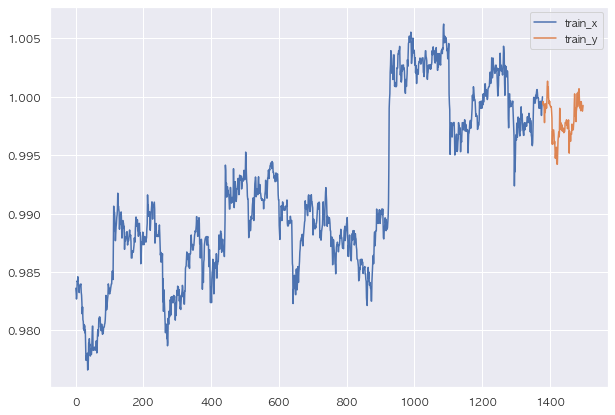

In [22]:
# sample_id가 idx인 그래프 그리기 
idx = 0
plt.plot(train_x_open.iloc[idx].values, label='train_x')
plt.plot(range(train_x_open.shape[1], train_x_open.shape[1]+train_y_open.shape[1]), train_y_open.iloc[idx].values, label='train_y')
plt.legend()
plt.show()

# 학습 및 예측

## train data의 단일 샘플에 대해 실행

In [50]:
# 시작 시간
start_time = '2021-01-31 00:00:00'
# 문자열 데이터 시계열 데이터로 변환
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
print(start_dt)     
type(start_dt)

2021-01-31 00:00:00


datetime.datetime

In [25]:
# datetime.timedelta는 두 날짜와 시간 사이의 차이를 계산할 때 사용합니다.
# 시작 시간 + 분(1분, 2분, 3분 ... 1380분)
# start_dt + datetime.timedelta(minutes = time_min)

In [37]:
# prophet 모델의 학습을 위한 데이터프레임 생성 (ds, y 칼럼)
idx = 2
x_df = pd.DataFrame()
# 시간(ds) 컬럼
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in range(1, train_x_open.shape[1]+1)]
# 시가(y) 컬럼
x_df['y'] = train_x_open.query(f'sample_id == {idx}').values.reshape(-1, 1)
x_df

,ds,y
0,2021-01-31 00:01:00,1.126241
1,2021-01-31 00:02:00,1.127214
2,2021-01-31 00:03:00,1.127751
3,2021-01-31 00:04:00,1.127717
4,2021-01-31 00:05:00,1.127214
...,...,...
1375,2021-01-31 22:56:00,0.991948
1376,2021-01-31 22:57:00,0.995471
1377,2021-01-31 22:58:00,1.001644
1378,2021-01-31 22:59:00,1.000772


In [38]:
model = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  changepoint_range=0.97,  
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정
                )
model.fit(x_df)

In [41]:
# 120분 예측
forecast = model.make_future_dataframe(periods=120, freq='min')
forecast_data = model.predict(forecast)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-31 00:01:00,1.129842,1.124999,1.134665
1,2021-01-31 00:02:00,1.129678,1.124697,1.134468
2,2021-01-31 00:03:00,1.129513,1.124840,1.134613
3,2021-01-31 00:04:00,1.129348,1.124890,1.134435
4,2021-01-31 00:05:00,1.129183,1.124584,1.133603
...,...,...,...,...
1495,2021-02-01 00:56:00,0.956077,0.916461,0.993581
1496,2021-02-01 00:57:00,0.955720,0.915981,0.994814
1497,2021-02-01 00:58:00,0.955363,0.915466,0.995536
1498,2021-02-01 00:59:00,0.955006,0.913251,0.994504


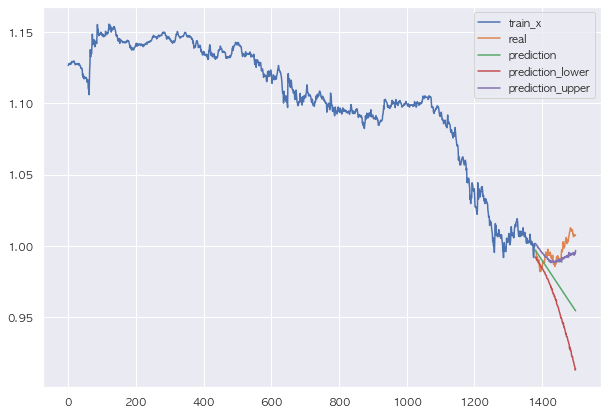

In [46]:
# 예측선 시각화
# 전체 1500개 데이터중(1380 + 120) 예측한 120분 데이터만 슬라이싱
y_pred = forecast_data['yhat'].values[-120:]
y_pred_lower = forecast_data['yhat_lower'].values[-120:]
y_pred_upper = forecast_data['yhat_upper'].values[-120:]

plt.plot(train_x_open.iloc[idx].values, label='train_x')
plt.plot(range(train_x_open.shape[1], train_x_open.shape[1]+train_y_open.shape[1]), train_y_open.iloc[idx].values, label='real')
# x: 1380분, y: 120분
plt.plot(range(train_x_open.shape[1], train_x_open.shape[1]+train_y_open.shape[1]), y_pred, label='prediction')
plt.plot(range(train_x_open.shape[1], train_x_open.shape[1]+train_y_open.shape[1]), y_pred_lower, label='prediction_lower')
plt.plot(range(train_x_open.shape[1], train_x_open.shape[1]+train_y_open.shape[1]), y_pred_upper, label='prediction_upper')
plt.legend()
plt.show()

## test data의 샘플 전체에 대해 실행

In [55]:
# (535, 120)
pred_test_array = np.zeros([test_x_open.shape[0], train_y_open.shape[1]])

# 학습 및 추론
# tqdm: 진행바 표시
# test 데이터 샘플 개수 만큼 실행
for idx in tqdm(range(test_x_open.shape[0])):
    # prophet 모델의 학습을 위한 데이터프레임 생성 (ds, y 칼럼)
    x_df = pd.DataFrame()
    # 시간(ds) 컬럼
    x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in range(1, train_x_open.shape[1]+1)]
    # 시가(y) 컬럼
    x_df['y'] = train_x_open.query(f'sample_id == {idx}').values.reshape(-1, 1)
    
    model = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  changepoint_range=0.97,  
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정
                )
    model.fit(x_df)

    # 120분 예측
    forecast = model.make_future_dataframe(periods=120, freq='min')
    forecast_data = model.predict(forecast)
    
    y_pred = forecast_data['yhat'].values[-120:]
    pred_test_array[idx, :] = y_pred

100%|██████████| 535/535 [1:17:22<00:00,  8.68s/it]


# 제출용 데이터프레임 생성

In [61]:
submission = pd.DataFrame()
submission['sample_id'] = range(train_x_open.shape[0], train_x_open.shape[0]+test_x_open.shape[0])
submission['buy_quantity'] = list(map(lambda x: 1 if max(x) > 1 else 0, pred_test_array))
submission['sell_time'] = np.argmax(pred_test_array, axis=1)
submission

,sample_id,buy_quantity,sell_time
0,7661,1,119
1,7662,1,119
2,7663,0,0
3,7664,1,119
4,7665,0,119
...,...,...,...
530,8191,1,119
531,8192,1,119
532,8193,1,119
533,8194,0,0


In [62]:
# submission.to_csv('submission_fbprophet.csv', index=False)